In [1]:
import sys
sys.path.insert(0,"..")
sys.path.insert(0, "../mwcnn/")
%matplotlib inline
import matplotlib.pyplot as plt

import torch, gc
from torch.utils.data import SubsetRandomSampler
import torch.optim as optim


from unet.model import UNet
from unet.unet_trainer import *

from gan.discriminator import Discriminator
from gan.gan_training import GANTrainer

from mwcnn import MWCNN
from training import MWCNNTrainer

from src.loss_functions import VGGPerceptualLoss
from src.dataset import ImageDataset
from src.utils import get_indices

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Dataset part used for testing
VALIDATION_SPLIT = 0.15
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 2
# Full Dataset path
TEST_DATASETS = ['val']
TRAIN_DATASETS = ['train']
ROOTDIR = '../data/'

# Training Epochs
EPOCHS = 100

IMAGESIZE = 256

gc.collect()
torch.cuda.empty_cache()

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may hav

In [2]:
train_image_dataset = ImageDataset(ROOTDIR, TRAIN_DATASETS, normalize="minmax", image_size=IMAGESIZE)
train_indices, validation_indices = get_indices(len(train_image_dataset), train_image_dataset.root_dir, VALIDATION_SPLIT, new=True)
train_sampler, validation_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(validation_indices)

trainloader = torch.utils.data.DataLoader(train_image_dataset, BATCH_SIZE, sampler=train_sampler)
validationloader = torch.utils.data.DataLoader(train_image_dataset, BATCH_SIZE, sampler=validation_sampler)

test_image_dataset = ImageDataset(ROOTDIR, TEST_DATASETS, normalize="minmax", image_size=IMAGESIZE)
testloader = torch.utils.data.DataLoader(test_image_dataset, 1)

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


## Pretrain UNET
First pretrain a UNET and MWCNN, afterwards, this can be used in the GAN set-up

In [3]:
# Filters used in UNet Model
filter_num = [16,32,64,128,256]
MODEL_NAME = f"models/UNet-{filter_num}.pt"
unet_model = UNet(filter_num).to(device)
# Start training.
unet_trainer = Unet_trainer(unet_model,device=device, learning_rate=0.002)
train_loss_record, validation_loss = unet_trainer.train(EPOCHS,trainloader,validationloader)
torch.save(unet_model.state_dict(), MODEL_NAME)

Starting Training Process
Epoch: 001,  Train Loss:0.0354891,  Validation Loss:0.0321256,  Time training: 0h0m10s
Epoch: 002,  Train Loss:0.0317903,  Validation Loss:0.0294596,  Time training: 0h0m16s
Epoch: 003,  Train Loss:0.0320968,  Validation Loss:0.0292956,  Time training: 0h0m21s
Epoch: 004,  Train Loss:0.0289324,  Validation Loss:0.0256522,  Time training: 0h0m26s
Epoch: 005,  Train Loss:0.0296510,  Validation Loss:0.0288655,  Time training: 0h0m31s
Epoch: 006,  Train Loss:0.0295268,  Validation Loss:0.0260919,  Time training: 0h0m36s
Epoch 00007: reducing learning rate of group 0 to 1.7000e-03.
Epoch: 007,  Train Loss:0.0292050,  Validation Loss:0.0254718,  Time training: 0h0m41s
Epoch: 008,  Train Loss:0.0255519,  Validation Loss:0.0217987,  Time training: 0h0m46s
Epoch: 009,  Train Loss:0.0244920,  Validation Loss:0.0261370,  Time training: 0h0m51s
Epoch: 010,  Train Loss:0.0221840,  Validation Loss:0.0212569,  Time training: 0h0m56s
Epoch: 011,  Train Loss:0.0218757,  Valida

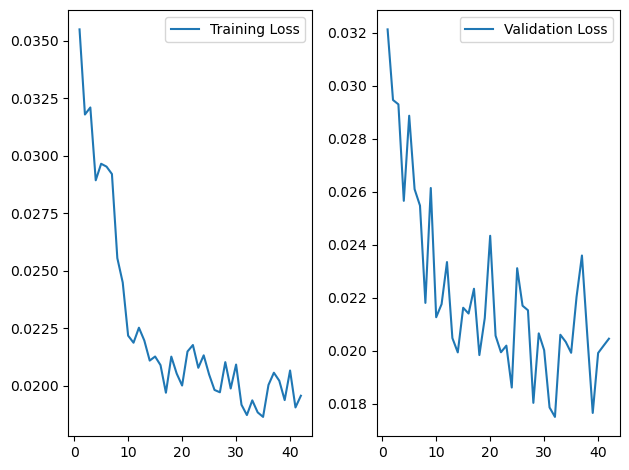

In [4]:
fig, ax = plt.subplots(nrows=1,ncols=2)
num_epochs = len(train_loss_record)
ax[0].plot(range(1, num_epochs + 1), train_loss_record, label='Training Loss')
ax[0].legend()
ax[1].plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss')
ax[1].legend()
plt.tight_layout()

## Train GAN with UNET


In [5]:
unet_discriminator = Discriminator(n_feats=64, patch_size=IMAGESIZE).to(device)
unet_gan_trainer = GANTrainer(unet_model, unet_discriminator, device=device, learning_rate=1e-3)

unet_gan_loss_record, unet_gan_validation_loss_record = unet_gan_trainer.train(EPOCHS, trainloader, validationloader)
torch.save(unet_model.state_dict(), f"models/GAN_UNet-{filter_num}.pt")

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Training Process


Epoch: 001,  Train Loss:50.5183864,  Validation Loss:50.5814217,  Time training: 0h1m3s
Epoch: 002,  Train Loss:50.6080837,  Validation Loss:50.5132913,  Time training: 0h2m5s
Epoch: 003,  Train Loss:50.5905275,  Validation Loss:50.5972275,  Time training: 0h3m8s
Epoch 00004: reducing learning rate of group 0 to 8.5000e-04.
Epoch: 004,  Train Loss:50.5626703,  Validation Loss:50.5340184,  Time training: 0h4m11s
Epoch: 005,  Train Loss:50.5707474,  Validation Loss:50.6130552,  Time training: 0h5m14s
Epoch: 006,  Train Loss:50.5844411,  Validation Loss:50.6018967,  Time training: 0h6m16s
Epoch 00007: reducing learning rate of group 0 to 7.2250e-04.
Epoch: 007,  Train Loss:50.5740365,  Validation Loss:50.5689736,  Time training: 0h7m19s
Epoch: 008,  Train Loss:50.5559546,  Validation Loss:50.5869792,  Time training: 0h8m22s
Epoch: 009,  Train Loss:50.5701350,  Validation Loss:50.5922492,  Time training: 0h9m24s
Epoch 00010: reducing learning rate of group 0 to 6.1412e-04.
Epoch: 010,  Tra

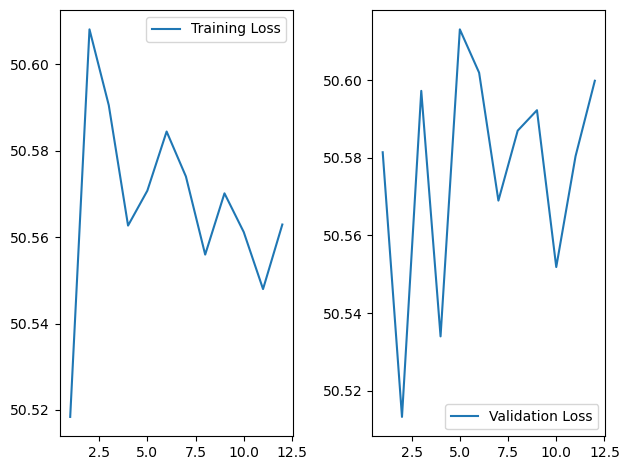

In [6]:
fig, ax = plt.subplots(nrows=1,ncols=2)
num_epochs = len(unet_gan_loss_record)
ax[0].plot(range(1, num_epochs + 1), unet_gan_loss_record, label='Training Loss')
ax[0].legend()
ax[1].plot(range(1, num_epochs + 1), unet_gan_validation_loss_record, label='Validation Loss')
ax[1].legend()
plt.tight_layout()

## Now do the same for MWCNN model

In [7]:
N_FEATS=64
MWCNN_model = MWCNN(n_feats=N_FEATS, n_colors=1, batch_normalize=True).to(device)
# Initialize trainer
MWCNN_trainer = MWCNNTrainer(
    MWCNN_model, learning_rate=1e-3,
    local_criterion=torch.nn.L1Loss(), global_criterion=None, 
    scale=0, device=device)
# Do training
train_loss_record, validation_loss = MWCNN_trainer.train(EPOCHS,trainloader, validationloader)
torch.save(MWCNN_model.state_dict(), f"models/none_mwcnn_feats_{N_FEATS}.pt")

Starting Training Process
Epoch: 001,  Train Loss:0.0488541,  Validation Loss:0.0301774,  Time training: 0h0m38s
Epoch: 002,  Train Loss:0.0349451,  Validation Loss:0.1222982,  Time training: 0h1m17s
Epoch: 003,  Train Loss:0.0314001,  Validation Loss:0.0526514,  Time training: 0h1m57s
Epoch: 004,  Train Loss:0.0302442,  Validation Loss:0.0987268,  Time training: 0h2m37s
Epoch: 005,  Train Loss:0.0268140,  Validation Loss:0.0645346,  Time training: 0h3m18s
Epoch: 006,  Train Loss:0.0252582,  Validation Loss:0.0468325,  Time training: 0h3m58s
Epoch: 007,  Train Loss:0.0244818,  Validation Loss:0.0344918,  Time training: 0h4m39s
Epoch: 008,  Train Loss:0.0233255,  Validation Loss:0.0256810,  Time training: 0h5m21s
Epoch: 009,  Train Loss:0.0233999,  Validation Loss:0.0339850,  Time training: 0h6m2s
Epoch: 010,  Train Loss:0.0222965,  Validation Loss:0.0417709,  Time training: 0h6m44s
Epoch: 011,  Train Loss:0.0234882,  Validation Loss:0.0297379,  Time training: 0h7m27s
Epoch: 012,  Train

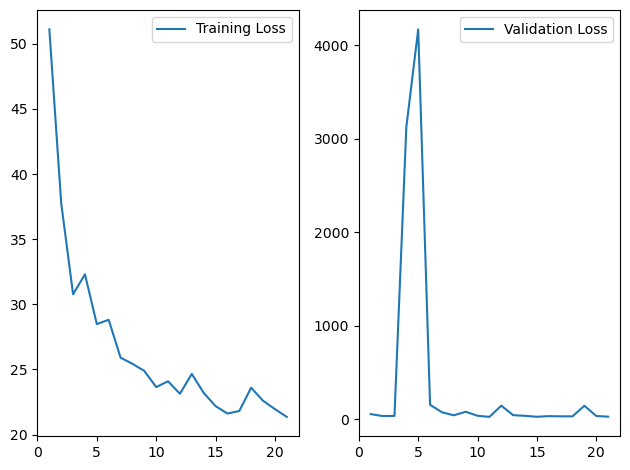

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=2)
num_epochs = len(train_loss_record)
ax[0].plot(range(1, num_epochs + 1), train_loss_record, label='Training Loss')
ax[0].legend()
ax[1].plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss')
ax[1].legend()
plt.tight_layout()

In [21]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.set_per_process_memory_fraction(0.9999, 0)

In [5]:

# make gan and train
mwcnn_discriminator = Discriminator(n_feats=64, patch_size=IMAGESIZE).to(device)
VGG_loss = VGGPerceptualLoss(resize=False).to(device)
mwcnn_gan_trainer = GANTrainer(MWCNN_model, discriminator=mwcnn_discriminator, 
                               device=device, model_file="models/mwcnn_none_gan.pt", learning_rate=1e-3)

mwcnn_gan_loss_record, mwcnn_gan_validation_loss_record = mwcnn_gan_trainer.train(EPOCHS, trainloader, validationloader)
torch.save(MWCNN_model.state_dict(), "models/mwcnn_none_gan.pt")

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Training Process
Epoch: 001,  Train Loss:509.2593557,  Validation Loss:1639.1447865,  Time training: 0h2m12s
Epoch: 002,  Train Loss:514.0680527,  Validation Loss:757.8224768,  Time training: 0h4m24s
Epoch: 003,  Train Loss:486.1404799,  Validation Loss:969.8735780,  Time training: 0h6m36s
Epoch: 004,  Train Loss:517.9830882,  Validation Loss:55293.0538841,  Time training: 0h8m48s
Epoch: 005,  Train Loss:524.3497657,  Validation Loss:5327.8170966,  Time training: 0h11m0s
Epoch 00006: reducing learning rate of group 0 to 8.5000e-04.
Epoch: 006,  Train Loss:519.9849453,  Validation Loss:1060.0194308,  Time training: 0h13m12s
Epoch: 007,  Train Loss:487.5598180,  Validation Loss:614.1017741,  Time training: 0h15m24s
Epoch: 008,  Train Loss:496.4297804,  Validation Loss:1160.6414152,  Time training: 0h17m34s
Epoch: 009,  Train Loss:486.0845673,  Validation Loss:618.6464209,  Time training: 0h19m45s
Epoch: 010,  Train Loss:471.8885883,  Validation Loss:612.6285209,  Time training: 

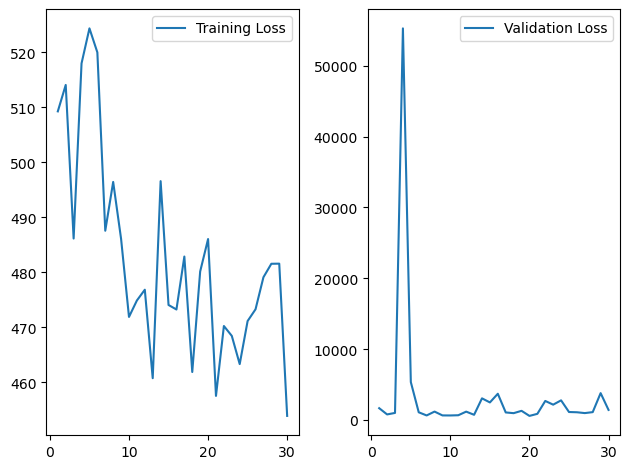

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=2)
num_epochs = len(mwcnn_gan_loss_record)
ax[0].plot(range(1, num_epochs + 1), mwcnn_gan_loss_record, label='Training Loss')
ax[0].legend()
ax[1].plot(range(1, num_epochs + 1), mwcnn_gan_validation_loss_record, label='Validation Loss')
ax[1].legend()
plt.tight_layout()